In [51]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
from collections import OrderedDict
import os
import neptune
from neptune.utils import stringify_unsupported

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [2]:
stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/freqRTheta.npz'
timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain.npz'
timeFreqSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeFreqRTheta.npz'

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/model.pth'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1.
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [52]:
epochs = 5000
batch_size = 1024
learningRate = 1e-3
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 5000

# UTILITY FUNCTIONS

In [32]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('bn%s' % str(i), nn.BatchNorm1d(sizeList[i])))
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# LOAD NUMPY DATA ARRAYS

In [5]:
dataSwitch = 'time'

if dataSwitch == 'freq':
    # STFT DATA

    npzfile = np.load(stftSavePath)
    x_trainRTheta = npzfile['x_trainRTheta']
    x_validRTheta = npzfile['x_validRTheta'] 
    y_trainRTheta = npzfile['y_trainRTheta'] 
    y_validRTheta = npzfile['y_validRTheta']

    trainXTensor = torch.Tensor(x_trainRTheta)
    trainYTensor = torch.Tensor(y_trainRTheta)
    validXTensor = torch.Tensor(x_validRTheta)
    validYTensor = torch.Tensor(y_validRTheta)

elif dataSwitch == 'time':
    # TIME DOMAIN DATA

    npzfile = np.load(timeDomainSavePath)
    xTrainTimeDomain = npzfile['xTrainTimeDomain']
    xValidTimeDomain = npzfile['xValidTimeDomain'] 
    yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
    yValidTimeDomain = npzfile['yValidTimeDomain']

    trainXTensor = torch.Tensor(xTrainTimeDomain)
    trainYTensor = torch.Tensor(yTrainTimeDomain)
    validXTensor = torch.Tensor(xValidTimeDomain)
    validYTensor = torch.Tensor(yValidTimeDomain)
    
elif dataSwitch == 'timeFreq':
    
    npzfile = np.load(timeFreqSavePath)
    xTrain = npzfile['x_trainTimeFreq']
    xValid = npzfile['x_validTimeFreq'] 
    yTrain = npzfile['y_trainTimeFreq'] 
    yValid = npzfile['y_validTimeFreq']

    trainXTensor = torch.Tensor(xTrain)
    trainYTensor = torch.Tensor(yTrain)
    validXTensor = torch.Tensor(xValid)
    validYTensor = torch.Tensor(yValid)

In [6]:
# CREATE PYTORCH DATALOADERS

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

validDataset = TensorDataset(validXTensor,validYTensor)
validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)


print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
print("\ntest: ")
for X, y in validDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

train: 
Shape of X [N, C, H, W]: torch.Size([512, 5655])
Shape of y: torch.Size([512, 1]) torch.float32

test: 
Shape of X [N, C, H, W]: torch.Size([512, 5655])
Shape of y: torch.Size([512, 1]) torch.float32


# DEFINE OR LOAD THE MODEL

In [35]:
# DEFINE MODEL

modelLoadFlag = False

if modelLoadFlag == True:
    model = torch.load(modelPath)
    bestTestLoss = test(validDataLoader, model, loss_fn)
else:
    # DEFINE ARCHITECTURE HERE
    hiddenLayerSizes = [512,512,512,512,512]
    
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = listToOrderedDict(layerSizeList)
    
    model = NeuralNetwork(layerOrderedDict)
    bestTestLoss = float('inf')
    
print("Number of parameters: ", count_parameters(model))
model = model.to(device)
print(model)

NeuralNetwork(
  (model): Sequential(
    (bn0): BatchNorm1d(5655, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l0): Linear(in_features=5655, out_features=512, bias=True)
    (r0): ReLU()
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (r1): ReLU()
    (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l2): Linear(in_features=512, out_features=512, bias=True)
    (r2): ReLU()
    (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l3): Linear(in_features=512, out_features=512, bias=True)
    (r3): ReLU()
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l4): Linear(in_features=512, out_features=512, bias=True)
    (r4): ReLU()
    (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (l5)

# TRAIN (LOG DATA TO NEPTUNE)

In [53]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn),
    "architectureString": str(model),
    "numParameters": count_parameters(model)
}
run["parameters"] = PARAMS

noImprovementCount = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(trainDataLoader, model, loss_fn, optimizer)
    test_loss = test(validDataLoader, model, loss_fn)
    
    if test_loss < bestTestLoss:
        noImprovementCount = 0
        bestTestLoss = test_loss
        torch.save(model, modelPath)
        run["model_best"].upload(modelPath)
        run["best_test_loss"] =  bestTestLoss
        run["best_test_epoch"] = t
        print("\nSaved a new best model!\n")
    else:
        noImprovementCount = noImprovementCount + 1
        
    run["train/loss"].append(train_loss)
    run["test/loss"].append(test_loss)
    
    if noImprovementCount >= patience:   
        print("Early stopping invoked....")
        break
        
run.stop()
print("Done!")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-35
Epoch 1
-------------------------------
loss: 0.327149  [  512/176128]
Test Error: 
 Avg loss: 0.858206 

Epoch 2
-------------------------------
loss: 0.645725  [  512/176128]
Test Error: 
 Avg loss: 0.596574 

Epoch 3
-------------------------------
loss: 0.478313  [  512/176128]
Test Error: 
 Avg loss: 0.538137 

Epoch 4
-------------------------------
loss: 0.486027  [  512/176128]
Test Error: 
 Avg loss: 0.557449 

Epoch 5
-------------------------------
loss: 0.457474  [  512/176128]
Test Error: 
 Avg loss: 0.548645 

Epoch 6
-------------------------------
loss: 0.443919  [  512/176128]
Test Error: 
 Avg loss: 0.552366 

Epoch 7
-------------------------------
loss: 0.441811  [  512/176128]
Test Error: 
 Avg loss: 0.605559 

Epoch 8
-------------------------------
loss: 0.440828  [  512/176128]
Test Error: 
 Avg loss: 0.652919 

Epoch 9
-------------------------------
loss: 0.455706  [  512/176128]
Test Error: 
 Avg lo

Test Error: 
 Avg loss: 0.451026 

Epoch 78
-------------------------------
loss: 0.380308  [  512/176128]
Test Error: 
 Avg loss: 0.441622 

Epoch 79
-------------------------------
loss: 0.343282  [  512/176128]
Test Error: 
 Avg loss: 0.432434 

Epoch 80
-------------------------------
loss: 0.329233  [  512/176128]
Test Error: 
 Avg loss: 0.436015 

Epoch 81
-------------------------------
loss: 0.321372  [  512/176128]
Test Error: 
 Avg loss: 0.440572 

Epoch 82
-------------------------------
loss: 0.334783  [  512/176128]
Test Error: 
 Avg loss: 0.448404 

Epoch 83
-------------------------------
loss: 0.360642  [  512/176128]
Test Error: 
 Avg loss: 0.451700 

Epoch 84
-------------------------------
loss: 0.305748  [  512/176128]
Test Error: 
 Avg loss: 0.450053 

Epoch 85
-------------------------------
loss: 0.331165  [  512/176128]
Test Error: 
 Avg loss: 0.445510 

Epoch 86
-------------------------------
loss: 0.322876  [  512/176128]
Test Error: 
 Avg loss: 0.444964 

Ep

Test Error: 
 Avg loss: 0.440322 

Epoch 155
-------------------------------
loss: 0.319260  [  512/176128]
Test Error: 
 Avg loss: 0.443206 

Epoch 156
-------------------------------
loss: 0.343276  [  512/176128]
Test Error: 
 Avg loss: 0.436805 

Epoch 157
-------------------------------
loss: 0.301789  [  512/176128]
Test Error: 
 Avg loss: 0.426044 

Epoch 158
-------------------------------
loss: 0.319704  [  512/176128]
Test Error: 
 Avg loss: 0.418425 

Epoch 159
-------------------------------
loss: 0.290201  [  512/176128]
Test Error: 
 Avg loss: 0.422290 

Epoch 160
-------------------------------
loss: 0.301483  [  512/176128]
Test Error: 
 Avg loss: 0.426326 

Epoch 161
-------------------------------
loss: 0.323795  [  512/176128]
Test Error: 
 Avg loss: 0.426120 

Epoch 162
-------------------------------
loss: 0.290897  [  512/176128]
Test Error: 
 Avg loss: 0.423985 

Epoch 163
-------------------------------
loss: 0.297202  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.435448 

Epoch 231
-------------------------------
loss: 0.299031  [  512/176128]
Test Error: 
 Avg loss: 0.439589 

Epoch 232
-------------------------------
loss: 0.303779  [  512/176128]
Test Error: 
 Avg loss: 0.439832 

Epoch 233
-------------------------------
loss: 0.296025  [  512/176128]
Test Error: 
 Avg loss: 0.430447 

Epoch 234
-------------------------------
loss: 0.322147  [  512/176128]
Test Error: 
 Avg loss: 0.423285 

Epoch 235
-------------------------------
loss: 0.270822  [  512/176128]
Test Error: 
 Avg loss: 0.422147 

Epoch 236
-------------------------------
loss: 0.289481  [  512/176128]
Test Error: 
 Avg loss: 0.421917 

Epoch 237
-------------------------------
loss: 0.316157  [  512/176128]
Test Error: 
 Avg loss: 0.416555 


Saved a new best model!

Epoch 238
-------------------------------
loss: 0.282710  [  512/176128]
Test Error: 
 Avg loss: 0.418030 

Epoch 239
-------------------------------
loss: 0.317881  [  512/176128]
Te

Test Error: 
 Avg loss: 0.427037 

Epoch 307
-------------------------------
loss: 0.298973  [  512/176128]
Test Error: 
 Avg loss: 0.428355 

Epoch 308
-------------------------------
loss: 0.322411  [  512/176128]
Test Error: 
 Avg loss: 0.427864 

Epoch 309
-------------------------------
loss: 0.276550  [  512/176128]
Test Error: 
 Avg loss: 0.433068 

Epoch 310
-------------------------------
loss: 0.295152  [  512/176128]
Test Error: 
 Avg loss: 0.439272 

Epoch 311
-------------------------------
loss: 0.277538  [  512/176128]
Test Error: 
 Avg loss: 0.437094 

Epoch 312
-------------------------------
loss: 0.280275  [  512/176128]
Test Error: 
 Avg loss: 0.437397 

Epoch 313
-------------------------------
loss: 0.268177  [  512/176128]
Test Error: 
 Avg loss: 0.438560 

Epoch 314
-------------------------------
loss: 0.333046  [  512/176128]
Test Error: 
 Avg loss: 0.426989 

Epoch 315
-------------------------------
loss: 0.300155  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.416487 

Epoch 383
-------------------------------
loss: 0.254578  [  512/176128]
Test Error: 
 Avg loss: 0.415656 

Epoch 384
-------------------------------
loss: 0.246409  [  512/176128]
Test Error: 
 Avg loss: 0.417089 

Epoch 385
-------------------------------
loss: 0.284611  [  512/176128]
Test Error: 
 Avg loss: 0.416166 

Epoch 386
-------------------------------
loss: 0.292765  [  512/176128]
Test Error: 
 Avg loss: 0.417839 

Epoch 387
-------------------------------
loss: 0.261727  [  512/176128]
Test Error: 
 Avg loss: 0.428544 

Epoch 388
-------------------------------
loss: 0.252585  [  512/176128]
Test Error: 
 Avg loss: 0.433695 

Epoch 389
-------------------------------
loss: 0.262673  [  512/176128]
Test Error: 
 Avg loss: 0.439374 

Epoch 390
-------------------------------
loss: 0.264459  [  512/176128]
Test Error: 
 Avg loss: 0.437302 

Epoch 391
-------------------------------
loss: 0.284221  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.420756 

Epoch 459
-------------------------------
loss: 0.253807  [  512/176128]
Test Error: 
 Avg loss: 0.427963 

Epoch 460
-------------------------------
loss: 0.257445  [  512/176128]
Test Error: 
 Avg loss: 0.434407 

Epoch 461
-------------------------------
loss: 0.263785  [  512/176128]
Test Error: 
 Avg loss: 0.437960 

Epoch 462
-------------------------------
loss: 0.275524  [  512/176128]
Test Error: 
 Avg loss: 0.434980 

Epoch 463
-------------------------------
loss: 0.287731  [  512/176128]
Test Error: 
 Avg loss: 0.428715 

Epoch 464
-------------------------------
loss: 0.271597  [  512/176128]
Test Error: 
 Avg loss: 0.432322 

Epoch 465
-------------------------------
loss: 0.250721  [  512/176128]
Test Error: 
 Avg loss: 0.442305 

Epoch 466
-------------------------------
loss: 0.257550  [  512/176128]
Test Error: 
 Avg loss: 0.450850 

Epoch 467
-------------------------------
loss: 0.287714  [  512/176128]
Test Error: 
 Avg loss: 0.44

Test Error: 
 Avg loss: 0.445105 

Epoch 535
-------------------------------
loss: 0.284653  [  512/176128]
Test Error: 
 Avg loss: 0.437069 

Epoch 536
-------------------------------
loss: 0.243881  [  512/176128]
Test Error: 
 Avg loss: 0.427116 

Epoch 537
-------------------------------
loss: 0.251152  [  512/176128]
Test Error: 
 Avg loss: 0.430699 

Epoch 538
-------------------------------
loss: 0.248653  [  512/176128]
Test Error: 
 Avg loss: 0.434734 

Epoch 539
-------------------------------
loss: 0.233068  [  512/176128]
Test Error: 
 Avg loss: 0.429641 

Epoch 540
-------------------------------
loss: 0.262251  [  512/176128]
Test Error: 
 Avg loss: 0.422393 

Epoch 541
-------------------------------
loss: 0.229937  [  512/176128]
Test Error: 
 Avg loss: 0.421342 

Epoch 542
-------------------------------
loss: 0.227802  [  512/176128]
Test Error: 
 Avg loss: 0.425531 

Epoch 543
-------------------------------
loss: 0.260137  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.422997 

Epoch 611
-------------------------------
loss: 0.238040  [  512/176128]
Test Error: 
 Avg loss: 0.424511 

Epoch 612
-------------------------------
loss: 0.252276  [  512/176128]
Test Error: 
 Avg loss: 0.429140 

Epoch 613
-------------------------------
loss: 0.239803  [  512/176128]
Test Error: 
 Avg loss: 0.432080 

Epoch 614
-------------------------------
loss: 0.238979  [  512/176128]
Test Error: 
 Avg loss: 0.429719 

Epoch 615
-------------------------------
loss: 0.226492  [  512/176128]
Test Error: 
 Avg loss: 0.425322 

Epoch 616
-------------------------------
loss: 0.207036  [  512/176128]
Test Error: 
 Avg loss: 0.426549 

Epoch 617
-------------------------------
loss: 0.217823  [  512/176128]
Test Error: 
 Avg loss: 0.431050 

Epoch 618
-------------------------------
loss: 0.249524  [  512/176128]
Test Error: 
 Avg loss: 0.432400 

Epoch 619
-------------------------------
loss: 0.240014  [  512/176128]
Test Error: 
 Avg loss: 0.43

Test Error: 
 Avg loss: 0.433374 

Epoch 687
-------------------------------
loss: 0.254538  [  512/176128]
Test Error: 
 Avg loss: 0.432254 

Epoch 688
-------------------------------
loss: 0.232622  [  512/176128]
Test Error: 
 Avg loss: 0.426863 

Epoch 689
-------------------------------
loss: 0.241287  [  512/176128]
Test Error: 
 Avg loss: 0.421794 

Epoch 690
-------------------------------
loss: 0.237482  [  512/176128]
Test Error: 
 Avg loss: 0.423535 

Epoch 691
-------------------------------
loss: 0.227443  [  512/176128]
Test Error: 
 Avg loss: 0.425636 

Epoch 692
-------------------------------
loss: 0.234919  [  512/176128]
Test Error: 
 Avg loss: 0.425937 

Epoch 693
-------------------------------
loss: 0.235302  [  512/176128]
Test Error: 
 Avg loss: 0.421335 

Epoch 694
-------------------------------
loss: 0.248145  [  512/176128]
Test Error: 
 Avg loss: 0.422649 

Epoch 695
-------------------------------
loss: 0.219407  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.421476 

Epoch 763
-------------------------------
loss: 0.222554  [  512/176128]
Test Error: 
 Avg loss: 0.422963 

Epoch 764
-------------------------------
loss: 0.204207  [  512/176128]
Test Error: 
 Avg loss: 0.426127 

Epoch 765
-------------------------------
loss: 0.211587  [  512/176128]
Test Error: 
 Avg loss: 0.426491 

Epoch 766
-------------------------------
loss: 0.224297  [  512/176128]
Test Error: 
 Avg loss: 0.423406 

Epoch 767
-------------------------------
loss: 0.234371  [  512/176128]
Test Error: 
 Avg loss: 0.421399 

Epoch 768
-------------------------------
loss: 0.214132  [  512/176128]
Test Error: 
 Avg loss: 0.424906 

Epoch 769
-------------------------------
loss: 0.212252  [  512/176128]
Test Error: 
 Avg loss: 0.429440 

Epoch 770
-------------------------------
loss: 0.213817  [  512/176128]
Test Error: 
 Avg loss: 0.430391 

Epoch 771
-------------------------------
loss: 0.227633  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.425275 

Epoch 839
-------------------------------
loss: 0.202409  [  512/176128]
Test Error: 
 Avg loss: 0.428542 

Epoch 840
-------------------------------
loss: 0.202653  [  512/176128]
Test Error: 
 Avg loss: 0.428393 

Epoch 841
-------------------------------
loss: 0.202501  [  512/176128]
Test Error: 
 Avg loss: 0.424943 

Epoch 842
-------------------------------
loss: 0.200423  [  512/176128]
Test Error: 
 Avg loss: 0.423303 

Epoch 843
-------------------------------
loss: 0.230842  [  512/176128]
Test Error: 
 Avg loss: 0.418099 

Epoch 844
-------------------------------
loss: 0.205035  [  512/176128]
Test Error: 
 Avg loss: 0.414482 

Epoch 845
-------------------------------
loss: 0.220152  [  512/176128]
Test Error: 
 Avg loss: 0.417359 

Epoch 846
-------------------------------
loss: 0.200143  [  512/176128]
Test Error: 
 Avg loss: 0.422243 

Epoch 847
-------------------------------
loss: 0.203653  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.429658 

Epoch 915
-------------------------------
loss: 0.190983  [  512/176128]
Test Error: 
 Avg loss: 0.434323 

Epoch 916
-------------------------------
loss: 0.224544  [  512/176128]
Test Error: 
 Avg loss: 0.439543 

Epoch 917
-------------------------------
loss: 0.188278  [  512/176128]
Test Error: 
 Avg loss: 0.440404 

Epoch 918
-------------------------------
loss: 0.214651  [  512/176128]
Test Error: 
 Avg loss: 0.434939 

Epoch 919
-------------------------------
loss: 0.193563  [  512/176128]
Test Error: 
 Avg loss: 0.425129 

Epoch 920
-------------------------------
loss: 0.236549  [  512/176128]
Test Error: 
 Avg loss: 0.419605 

Epoch 921
-------------------------------
loss: 0.205693  [  512/176128]
Test Error: 
 Avg loss: 0.423022 

Epoch 922
-------------------------------
loss: 0.202079  [  512/176128]
Test Error: 
 Avg loss: 0.425535 

Epoch 923
-------------------------------
loss: 0.198587  [  512/176128]
Test Error: 
 Avg loss: 0.42

Test Error: 
 Avg loss: 0.424015 

Epoch 991
-------------------------------
loss: 0.212783  [  512/176128]
Test Error: 
 Avg loss: 0.421704 

Epoch 992
-------------------------------
loss: 0.189553  [  512/176128]
Test Error: 
 Avg loss: 0.431796 

Epoch 993
-------------------------------
loss: 0.208339  [  512/176128]
Test Error: 
 Avg loss: 0.442687 

Epoch 994
-------------------------------
loss: 0.205528  [  512/176128]
Test Error: 
 Avg loss: 0.444401 

Epoch 995
-------------------------------
loss: 0.219380  [  512/176128]
Test Error: 
 Avg loss: 0.442216 

Epoch 996
-------------------------------
loss: 0.199225  [  512/176128]
Test Error: 
 Avg loss: 0.436198 

Epoch 997
-------------------------------
loss: 0.200992  [  512/176128]
Test Error: 
 Avg loss: 0.437801 

Epoch 998
-------------------------------
loss: 0.220996  [  512/176128]
Test Error: 
 Avg loss: 0.443340 

Epoch 999
-------------------------------
loss: 0.207082  [  512/176128]
Test Error: 
 Avg loss: 0.44

Test Error: 
 Avg loss: 0.426901 

Epoch 1067
-------------------------------
loss: 0.200672  [  512/176128]
Test Error: 
 Avg loss: 0.427844 

Epoch 1068
-------------------------------
loss: 0.185202  [  512/176128]
Test Error: 
 Avg loss: 0.428416 

Epoch 1069
-------------------------------
loss: 0.205152  [  512/176128]
Test Error: 
 Avg loss: 0.429401 

Epoch 1070
-------------------------------
loss: 0.185903  [  512/176128]
Test Error: 
 Avg loss: 0.431307 

Epoch 1071
-------------------------------
loss: 0.214838  [  512/176128]
Test Error: 
 Avg loss: 0.435285 

Epoch 1072
-------------------------------
loss: 0.219010  [  512/176128]
Test Error: 
 Avg loss: 0.436671 

Epoch 1073
-------------------------------
loss: 0.201532  [  512/176128]
Test Error: 
 Avg loss: 0.435687 

Epoch 1074
-------------------------------
loss: 0.190959  [  512/176128]
Test Error: 
 Avg loss: 0.434727 

Epoch 1075
-------------------------------
loss: 0.197131  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.425548 

Epoch 1143
-------------------------------
loss: 0.201843  [  512/176128]
Test Error: 
 Avg loss: 0.419990 

Epoch 1144
-------------------------------
loss: 0.204941  [  512/176128]
Test Error: 
 Avg loss: 0.419611 

Epoch 1145
-------------------------------
loss: 0.182989  [  512/176128]
Test Error: 
 Avg loss: 0.428321 

Epoch 1146
-------------------------------
loss: 0.201861  [  512/176128]
Test Error: 
 Avg loss: 0.433379 

Epoch 1147
-------------------------------
loss: 0.197960  [  512/176128]
Test Error: 
 Avg loss: 0.432964 

Epoch 1148
-------------------------------
loss: 0.226393  [  512/176128]
Test Error: 
 Avg loss: 0.426704 

Epoch 1149
-------------------------------
loss: 0.192352  [  512/176128]
Test Error: 
 Avg loss: 0.422130 

Epoch 1150
-------------------------------
loss: 0.209228  [  512/176128]
Test Error: 
 Avg loss: 0.422087 

Epoch 1151
-------------------------------
loss: 0.189616  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.422463 

Epoch 1219
-------------------------------
loss: 0.197890  [  512/176128]
Test Error: 
 Avg loss: 0.424508 

Epoch 1220
-------------------------------
loss: 0.194925  [  512/176128]
Test Error: 
 Avg loss: 0.422692 

Epoch 1221
-------------------------------
loss: 0.194478  [  512/176128]
Test Error: 
 Avg loss: 0.420738 

Epoch 1222
-------------------------------
loss: 0.199494  [  512/176128]
Test Error: 
 Avg loss: 0.419657 

Epoch 1223
-------------------------------
loss: 0.202340  [  512/176128]
Test Error: 
 Avg loss: 0.419996 

Epoch 1224
-------------------------------
loss: 0.188481  [  512/176128]
Test Error: 
 Avg loss: 0.419586 

Epoch 1225
-------------------------------
loss: 0.185747  [  512/176128]
Test Error: 
 Avg loss: 0.418206 

Epoch 1226
-------------------------------
loss: 0.214623  [  512/176128]
Test Error: 
 Avg loss: 0.419446 

Epoch 1227
-------------------------------
loss: 0.189558  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.426813 

Epoch 1295
-------------------------------
loss: 0.193595  [  512/176128]
Test Error: 
 Avg loss: 0.422938 

Epoch 1296
-------------------------------
loss: 0.192616  [  512/176128]
Test Error: 
 Avg loss: 0.425542 

Epoch 1297
-------------------------------
loss: 0.198616  [  512/176128]
Test Error: 
 Avg loss: 0.426206 

Epoch 1298
-------------------------------
loss: 0.189383  [  512/176128]
Test Error: 
 Avg loss: 0.424062 

Epoch 1299
-------------------------------
loss: 0.196985  [  512/176128]
Test Error: 
 Avg loss: 0.424204 

Epoch 1300
-------------------------------
loss: 0.192668  [  512/176128]
Test Error: 
 Avg loss: 0.433922 

Epoch 1301
-------------------------------
loss: 0.188825  [  512/176128]
Test Error: 
 Avg loss: 0.446393 

Epoch 1302
-------------------------------
loss: 0.174358  [  512/176128]
Test Error: 
 Avg loss: 0.449977 

Epoch 1303
-------------------------------
loss: 0.186444  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.420772 

Epoch 1371
-------------------------------
loss: 0.186563  [  512/176128]
Test Error: 
 Avg loss: 0.423824 

Epoch 1372
-------------------------------
loss: 0.175050  [  512/176128]
Test Error: 
 Avg loss: 0.428313 

Epoch 1373
-------------------------------
loss: 0.182286  [  512/176128]
Test Error: 
 Avg loss: 0.430603 

Epoch 1374
-------------------------------
loss: 0.182891  [  512/176128]
Test Error: 
 Avg loss: 0.431842 

Epoch 1375
-------------------------------
loss: 0.181233  [  512/176128]
Test Error: 
 Avg loss: 0.435627 

Epoch 1376
-------------------------------
loss: 0.169680  [  512/176128]
Test Error: 
 Avg loss: 0.436617 

Epoch 1377
-------------------------------
loss: 0.193296  [  512/176128]
Test Error: 
 Avg loss: 0.433726 

Epoch 1378
-------------------------------
loss: 0.196174  [  512/176128]
Test Error: 
 Avg loss: 0.428258 

Epoch 1379
-------------------------------
loss: 0.184536  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.424581 

Epoch 1446
-------------------------------
loss: 0.198936  [  512/176128]
Test Error: 
 Avg loss: 0.422075 

Epoch 1447
-------------------------------
loss: 0.158492  [  512/176128]
Test Error: 
 Avg loss: 0.422754 

Epoch 1448
-------------------------------
loss: 0.170606  [  512/176128]
Test Error: 
 Avg loss: 0.424015 

Epoch 1449
-------------------------------
loss: 0.160289  [  512/176128]
Test Error: 
 Avg loss: 0.426782 

Epoch 1450
-------------------------------
loss: 0.183923  [  512/176128]
Test Error: 
 Avg loss: 0.427297 

Epoch 1451
-------------------------------
loss: 0.193062  [  512/176128]
Test Error: 
 Avg loss: 0.427082 

Epoch 1452
-------------------------------
loss: 0.166307  [  512/176128]
Test Error: 
 Avg loss: 0.423528 

Epoch 1453
-------------------------------
loss: 0.173961  [  512/176128]
Test Error: 
 Avg loss: 0.423242 

Epoch 1454
-------------------------------
loss: 0.157039  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.429121 

Epoch 1522
-------------------------------
loss: 0.183066  [  512/176128]
Test Error: 
 Avg loss: 0.423341 

Epoch 1523
-------------------------------
loss: 0.178979  [  512/176128]
Test Error: 
 Avg loss: 0.422855 

Epoch 1524
-------------------------------
loss: 0.170458  [  512/176128]
Test Error: 
 Avg loss: 0.421754 

Epoch 1525
-------------------------------
loss: 0.164206  [  512/176128]
Test Error: 
 Avg loss: 0.422481 

Epoch 1526
-------------------------------
loss: 0.185401  [  512/176128]
Test Error: 
 Avg loss: 0.422507 

Epoch 1527
-------------------------------
loss: 0.175417  [  512/176128]
Test Error: 
 Avg loss: 0.423367 

Epoch 1528
-------------------------------
loss: 0.176743  [  512/176128]
Test Error: 
 Avg loss: 0.424895 

Epoch 1529
-------------------------------
loss: 0.195224  [  512/176128]
Test Error: 
 Avg loss: 0.426742 

Epoch 1530
-------------------------------
loss: 0.164383  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.427409 

Epoch 1598
-------------------------------
loss: 0.165573  [  512/176128]
Test Error: 
 Avg loss: 0.431363 

Epoch 1599
-------------------------------
loss: 0.155823  [  512/176128]
Test Error: 
 Avg loss: 0.430847 

Epoch 1600
-------------------------------
loss: 0.170516  [  512/176128]
Test Error: 
 Avg loss: 0.430350 

Epoch 1601
-------------------------------
loss: 0.177540  [  512/176128]
Test Error: 
 Avg loss: 0.432113 

Epoch 1602
-------------------------------
loss: 0.161814  [  512/176128]
Test Error: 
 Avg loss: 0.433904 

Epoch 1603
-------------------------------
loss: 0.184755  [  512/176128]
Test Error: 
 Avg loss: 0.433901 

Epoch 1604
-------------------------------
loss: 0.179978  [  512/176128]
Test Error: 
 Avg loss: 0.431969 

Epoch 1605
-------------------------------
loss: 0.165663  [  512/176128]
Test Error: 
 Avg loss: 0.430912 

Epoch 1606
-------------------------------
loss: 0.177457  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.420969 

Epoch 1674
-------------------------------
loss: 0.156355  [  512/176128]
Test Error: 
 Avg loss: 0.423815 

Epoch 1675
-------------------------------
loss: 0.168871  [  512/176128]
Test Error: 
 Avg loss: 0.426145 

Epoch 1676
-------------------------------
loss: 0.196318  [  512/176128]
Test Error: 
 Avg loss: 0.424693 

Epoch 1677
-------------------------------
loss: 0.175791  [  512/176128]
Test Error: 
 Avg loss: 0.422413 

Epoch 1678
-------------------------------
loss: 0.178333  [  512/176128]
Test Error: 
 Avg loss: 0.425002 

Epoch 1679
-------------------------------
loss: 0.186263  [  512/176128]
Test Error: 
 Avg loss: 0.427093 

Epoch 1680
-------------------------------
loss: 0.172324  [  512/176128]
Test Error: 
 Avg loss: 0.425901 

Epoch 1681
-------------------------------
loss: 0.169826  [  512/176128]
Test Error: 
 Avg loss: 0.421421 

Epoch 1682
-------------------------------
loss: 0.157968  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.429858 

Epoch 1750
-------------------------------
loss: 0.175301  [  512/176128]
Test Error: 
 Avg loss: 0.428573 

Epoch 1751
-------------------------------
loss: 0.153283  [  512/176128]
Test Error: 
 Avg loss: 0.426123 

Epoch 1752
-------------------------------
loss: 0.158878  [  512/176128]
Test Error: 
 Avg loss: 0.427072 

Epoch 1753
-------------------------------
loss: 0.171171  [  512/176128]
Test Error: 
 Avg loss: 0.436257 

Epoch 1754
-------------------------------
loss: 0.153948  [  512/176128]
Test Error: 
 Avg loss: 0.447270 

Epoch 1755
-------------------------------
loss: 0.165055  [  512/176128]
Test Error: 
 Avg loss: 0.452781 

Epoch 1756
-------------------------------
loss: 0.189404  [  512/176128]
Test Error: 
 Avg loss: 0.444663 

Epoch 1757
-------------------------------
loss: 0.184180  [  512/176128]
Test Error: 
 Avg loss: 0.436738 

Epoch 1758
-------------------------------
loss: 0.182693  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.414196 

Epoch 1826
-------------------------------
loss: 0.180893  [  512/176128]
Test Error: 
 Avg loss: 0.414188 

Epoch 1827
-------------------------------
loss: 0.167954  [  512/176128]
Test Error: 
 Avg loss: 0.414590 

Epoch 1828
-------------------------------
loss: 0.178273  [  512/176128]
Test Error: 
 Avg loss: 0.417121 

Epoch 1829
-------------------------------
loss: 0.172335  [  512/176128]
Test Error: 
 Avg loss: 0.419138 

Epoch 1830
-------------------------------
loss: 0.158823  [  512/176128]
Test Error: 
 Avg loss: 0.419854 

Epoch 1831
-------------------------------
loss: 0.156429  [  512/176128]
Test Error: 
 Avg loss: 0.422180 

Epoch 1832
-------------------------------
loss: 0.166056  [  512/176128]
Test Error: 
 Avg loss: 0.422610 

Epoch 1833
-------------------------------
loss: 0.181907  [  512/176128]
Test Error: 
 Avg loss: 0.424939 

Epoch 1834
-------------------------------
loss: 0.159200  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.435351 

Epoch 1902
-------------------------------
loss: 0.164080  [  512/176128]
Test Error: 
 Avg loss: 0.428146 

Epoch 1903
-------------------------------
loss: 0.166009  [  512/176128]
Test Error: 
 Avg loss: 0.423147 

Epoch 1904
-------------------------------
loss: 0.142817  [  512/176128]
Test Error: 
 Avg loss: 0.424178 

Epoch 1905
-------------------------------
loss: 0.148339  [  512/176128]
Test Error: 
 Avg loss: 0.429137 

Epoch 1906
-------------------------------
loss: 0.155797  [  512/176128]
Test Error: 
 Avg loss: 0.429617 

Epoch 1907
-------------------------------
loss: 0.180657  [  512/176128]
Test Error: 
 Avg loss: 0.425705 

Epoch 1908
-------------------------------
loss: 0.169888  [  512/176128]
Test Error: 
 Avg loss: 0.419639 

Epoch 1909
-------------------------------
loss: 0.168769  [  512/176128]
Test Error: 
 Avg loss: 0.414823 

Epoch 1910
-------------------------------
loss: 0.132411  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.419038 

Epoch 1978
-------------------------------
loss: 0.156289  [  512/176128]
Test Error: 
 Avg loss: 0.422905 

Epoch 1979
-------------------------------
loss: 0.151487  [  512/176128]
Test Error: 
 Avg loss: 0.427047 

Epoch 1980
-------------------------------
loss: 0.145247  [  512/176128]
Test Error: 
 Avg loss: 0.429397 

Epoch 1981
-------------------------------
loss: 0.169031  [  512/176128]
Test Error: 
 Avg loss: 0.428597 

Epoch 1982
-------------------------------
loss: 0.158464  [  512/176128]
Test Error: 
 Avg loss: 0.425168 

Epoch 1983
-------------------------------
loss: 0.144236  [  512/176128]
Test Error: 
 Avg loss: 0.426967 

Epoch 1984
-------------------------------
loss: 0.147972  [  512/176128]
Test Error: 
 Avg loss: 0.426536 

Epoch 1985
-------------------------------
loss: 0.155887  [  512/176128]
Test Error: 
 Avg loss: 0.426116 

Epoch 1986
-------------------------------
loss: 0.165685  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.432823 

Epoch 2054
-------------------------------
loss: 0.153766  [  512/176128]
Test Error: 
 Avg loss: 0.437621 

Epoch 2055
-------------------------------
loss: 0.173852  [  512/176128]
Test Error: 
 Avg loss: 0.436114 

Epoch 2056
-------------------------------
loss: 0.162094  [  512/176128]
Test Error: 
 Avg loss: 0.432037 

Epoch 2057
-------------------------------
loss: 0.151031  [  512/176128]
Test Error: 
 Avg loss: 0.434981 

Epoch 2058
-------------------------------
loss: 0.138714  [  512/176128]
Test Error: 
 Avg loss: 0.440627 

Epoch 2059
-------------------------------
loss: 0.150272  [  512/176128]
Test Error: 
 Avg loss: 0.443599 

Epoch 2060
-------------------------------
loss: 0.147762  [  512/176128]
Test Error: 
 Avg loss: 0.439730 

Epoch 2061
-------------------------------
loss: 0.176772  [  512/176128]
Test Error: 
 Avg loss: 0.431391 

Epoch 2062
-------------------------------
loss: 0.171927  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.427869 

Epoch 2130
-------------------------------
loss: 0.151328  [  512/176128]
Test Error: 
 Avg loss: 0.421504 

Epoch 2131
-------------------------------
loss: 0.147586  [  512/176128]
Test Error: 
 Avg loss: 0.416504 

Epoch 2132
-------------------------------
loss: 0.146455  [  512/176128]
Test Error: 
 Avg loss: 0.416180 

Epoch 2133
-------------------------------
loss: 0.136683  [  512/176128]
Test Error: 
 Avg loss: 0.419751 

Epoch 2134
-------------------------------
loss: 0.153168  [  512/176128]
Test Error: 
 Avg loss: 0.421674 

Epoch 2135
-------------------------------
loss: 0.167979  [  512/176128]
Test Error: 
 Avg loss: 0.421485 

Epoch 2136
-------------------------------
loss: 0.161798  [  512/176128]
Test Error: 
 Avg loss: 0.422747 

Epoch 2137
-------------------------------
loss: 0.139715  [  512/176128]
Test Error: 
 Avg loss: 0.424308 

Epoch 2138
-------------------------------
loss: 0.146545  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.423903 

Epoch 2206
-------------------------------
loss: 0.157881  [  512/176128]
Test Error: 
 Avg loss: 0.424669 

Epoch 2207
-------------------------------
loss: 0.158422  [  512/176128]
Test Error: 
 Avg loss: 0.425315 

Epoch 2208
-------------------------------
loss: 0.166140  [  512/176128]
Test Error: 
 Avg loss: 0.424170 

Epoch 2209
-------------------------------
loss: 0.141100  [  512/176128]
Test Error: 
 Avg loss: 0.421272 

Epoch 2210
-------------------------------
loss: 0.147402  [  512/176128]
Test Error: 
 Avg loss: 0.419246 

Epoch 2211
-------------------------------
loss: 0.154632  [  512/176128]
Test Error: 
 Avg loss: 0.416500 

Epoch 2212
-------------------------------
loss: 0.143945  [  512/176128]
Test Error: 
 Avg loss: 0.417992 

Epoch 2213
-------------------------------
loss: 0.145995  [  512/176128]
Test Error: 
 Avg loss: 0.420485 

Epoch 2214
-------------------------------
loss: 0.169253  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.420549 

Epoch 2282
-------------------------------
loss: 0.161310  [  512/176128]
Test Error: 
 Avg loss: 0.420079 

Epoch 2283
-------------------------------
loss: 0.143114  [  512/176128]
Test Error: 
 Avg loss: 0.415604 

Epoch 2284
-------------------------------
loss: 0.152792  [  512/176128]
Test Error: 
 Avg loss: 0.413654 

Epoch 2285
-------------------------------
loss: 0.147158  [  512/176128]
Test Error: 
 Avg loss: 0.414863 

Epoch 2286
-------------------------------
loss: 0.138836  [  512/176128]
Test Error: 
 Avg loss: 0.418311 

Epoch 2287
-------------------------------
loss: 0.176453  [  512/176128]
Test Error: 
 Avg loss: 0.419147 

Epoch 2288
-------------------------------
loss: 0.149691  [  512/176128]
Test Error: 
 Avg loss: 0.417634 

Epoch 2289
-------------------------------
loss: 0.142787  [  512/176128]
Test Error: 
 Avg loss: 0.417554 

Epoch 2290
-------------------------------
loss: 0.194412  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416142 

Epoch 2358
-------------------------------
loss: 0.140460  [  512/176128]
Test Error: 
 Avg loss: 0.415950 

Epoch 2359
-------------------------------
loss: 0.154242  [  512/176128]
Test Error: 
 Avg loss: 0.414130 

Epoch 2360
-------------------------------
loss: 0.141661  [  512/176128]
Test Error: 
 Avg loss: 0.414496 

Epoch 2361
-------------------------------
loss: 0.137647  [  512/176128]
Test Error: 
 Avg loss: 0.415692 

Epoch 2362
-------------------------------
loss: 0.136479  [  512/176128]
Test Error: 
 Avg loss: 0.417189 

Epoch 2363
-------------------------------
loss: 0.146896  [  512/176128]
Test Error: 
 Avg loss: 0.418243 

Epoch 2364
-------------------------------
loss: 0.157717  [  512/176128]
Test Error: 
 Avg loss: 0.420216 

Epoch 2365
-------------------------------
loss: 0.160030  [  512/176128]
Test Error: 
 Avg loss: 0.420130 

Epoch 2366
-------------------------------
loss: 0.150914  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.411975 

Epoch 2434
-------------------------------
loss: 0.137713  [  512/176128]
Test Error: 
 Avg loss: 0.413975 

Epoch 2435
-------------------------------
loss: 0.138372  [  512/176128]
Test Error: 
 Avg loss: 0.416259 

Epoch 2436
-------------------------------
loss: 0.150604  [  512/176128]
Test Error: 
 Avg loss: 0.419430 

Epoch 2437
-------------------------------
loss: 0.141212  [  512/176128]
Test Error: 
 Avg loss: 0.421402 

Epoch 2438
-------------------------------
loss: 0.134139  [  512/176128]
Test Error: 
 Avg loss: 0.421930 

Epoch 2439
-------------------------------
loss: 0.146201  [  512/176128]
Test Error: 
 Avg loss: 0.421410 

Epoch 2440
-------------------------------
loss: 0.137712  [  512/176128]
Test Error: 
 Avg loss: 0.419906 

Epoch 2441
-------------------------------
loss: 0.144801  [  512/176128]
Test Error: 
 Avg loss: 0.420935 

Epoch 2442
-------------------------------
loss: 0.144137  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.423920 

Epoch 2510
-------------------------------
loss: 0.151626  [  512/176128]
Test Error: 
 Avg loss: 0.421890 

Epoch 2511
-------------------------------
loss: 0.146358  [  512/176128]
Test Error: 
 Avg loss: 0.421558 

Epoch 2512
-------------------------------
loss: 0.153365  [  512/176128]
Test Error: 
 Avg loss: 0.420873 

Epoch 2513
-------------------------------
loss: 0.167388  [  512/176128]
Test Error: 
 Avg loss: 0.423390 

Epoch 2514
-------------------------------
loss: 0.154229  [  512/176128]
Test Error: 
 Avg loss: 0.424772 

Epoch 2515
-------------------------------
loss: 0.154751  [  512/176128]
Test Error: 
 Avg loss: 0.424487 

Epoch 2516
-------------------------------
loss: 0.143655  [  512/176128]
Test Error: 
 Avg loss: 0.422948 

Epoch 2517
-------------------------------
loss: 0.140600  [  512/176128]
Test Error: 
 Avg loss: 0.422130 

Epoch 2518
-------------------------------
loss: 0.183185  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.423476 

Epoch 2586
-------------------------------
loss: 0.146933  [  512/176128]
Test Error: 
 Avg loss: 0.425498 

Epoch 2587
-------------------------------
loss: 0.145577  [  512/176128]
Test Error: 
 Avg loss: 0.425591 

Epoch 2588
-------------------------------
loss: 0.142597  [  512/176128]
Test Error: 
 Avg loss: 0.422819 

Epoch 2589
-------------------------------
loss: 0.141405  [  512/176128]
Test Error: 
 Avg loss: 0.421924 

Epoch 2590
-------------------------------
loss: 0.138545  [  512/176128]
Test Error: 
 Avg loss: 0.424399 

Epoch 2591
-------------------------------
loss: 0.129583  [  512/176128]
Test Error: 
 Avg loss: 0.427335 

Epoch 2592
-------------------------------
loss: 0.150781  [  512/176128]
Test Error: 
 Avg loss: 0.425897 

Epoch 2593
-------------------------------
loss: 0.143556  [  512/176128]
Test Error: 
 Avg loss: 0.424267 

Epoch 2594
-------------------------------
loss: 0.145700  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.426195 

Epoch 2662
-------------------------------
loss: 0.144649  [  512/176128]
Test Error: 
 Avg loss: 0.424324 

Epoch 2663
-------------------------------
loss: 0.149987  [  512/176128]
Test Error: 
 Avg loss: 0.420424 

Epoch 2664
-------------------------------
loss: 0.145217  [  512/176128]
Test Error: 
 Avg loss: 0.417141 

Epoch 2665
-------------------------------
loss: 0.140960  [  512/176128]
Test Error: 
 Avg loss: 0.415755 

Epoch 2666
-------------------------------
loss: 0.133061  [  512/176128]
Test Error: 
 Avg loss: 0.416807 

Epoch 2667
-------------------------------
loss: 0.128319  [  512/176128]
Test Error: 
 Avg loss: 0.418781 

Epoch 2668
-------------------------------
loss: 0.156945  [  512/176128]
Test Error: 
 Avg loss: 0.416654 

Epoch 2669
-------------------------------
loss: 0.156806  [  512/176128]
Test Error: 
 Avg loss: 0.413282 

Epoch 2670
-------------------------------
loss: 0.171201  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.420973 

Epoch 2737
-------------------------------
loss: 0.136340  [  512/176128]
Test Error: 
 Avg loss: 0.422257 

Epoch 2738
-------------------------------
loss: 0.135332  [  512/176128]
Test Error: 
 Avg loss: 0.423856 

Epoch 2739
-------------------------------
loss: 0.140680  [  512/176128]
Test Error: 
 Avg loss: 0.423807 

Epoch 2740
-------------------------------
loss: 0.157482  [  512/176128]
Test Error: 
 Avg loss: 0.422854 

Epoch 2741
-------------------------------
loss: 0.132719  [  512/176128]
Test Error: 
 Avg loss: 0.420571 

Epoch 2742
-------------------------------
loss: 0.132476  [  512/176128]
Test Error: 
 Avg loss: 0.417415 

Epoch 2743
-------------------------------
loss: 0.132138  [  512/176128]
Test Error: 
 Avg loss: 0.417874 

Epoch 2744
-------------------------------
loss: 0.144153  [  512/176128]
Test Error: 
 Avg loss: 0.415612 

Epoch 2745
-------------------------------
loss: 0.145137  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.415538 

Epoch 2813
-------------------------------
loss: 0.156278  [  512/176128]
Test Error: 
 Avg loss: 0.415414 

Epoch 2814
-------------------------------
loss: 0.149555  [  512/176128]
Test Error: 
 Avg loss: 0.415314 

Epoch 2815
-------------------------------
loss: 0.141615  [  512/176128]
Test Error: 
 Avg loss: 0.412641 

Epoch 2816
-------------------------------
loss: 0.130934  [  512/176128]
Test Error: 
 Avg loss: 0.410642 

Epoch 2817
-------------------------------
loss: 0.134839  [  512/176128]
Test Error: 
 Avg loss: 0.410853 

Epoch 2818
-------------------------------
loss: 0.124478  [  512/176128]
Test Error: 
 Avg loss: 0.414261 

Epoch 2819
-------------------------------
loss: 0.150090  [  512/176128]
Test Error: 
 Avg loss: 0.415893 

Epoch 2820
-------------------------------
loss: 0.146294  [  512/176128]
Test Error: 
 Avg loss: 0.414688 

Epoch 2821
-------------------------------
loss: 0.129829  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.419527 

Epoch 2889
-------------------------------
loss: 0.138112  [  512/176128]
Test Error: 
 Avg loss: 0.419291 

Epoch 2890
-------------------------------
loss: 0.127328  [  512/176128]
Test Error: 
 Avg loss: 0.420299 

Epoch 2891
-------------------------------
loss: 0.139983  [  512/176128]
Test Error: 
 Avg loss: 0.420731 

Epoch 2892
-------------------------------
loss: 0.153252  [  512/176128]
Test Error: 
 Avg loss: 0.418144 

Epoch 2893
-------------------------------
loss: 0.134057  [  512/176128]
Test Error: 
 Avg loss: 0.414440 

Epoch 2894
-------------------------------
loss: 0.124325  [  512/176128]
Test Error: 
 Avg loss: 0.415355 

Epoch 2895
-------------------------------
loss: 0.136009  [  512/176128]
Test Error: 
 Avg loss: 0.416040 

Epoch 2896
-------------------------------
loss: 0.125881  [  512/176128]
Test Error: 
 Avg loss: 0.415324 

Epoch 2897
-------------------------------
loss: 0.129792  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.417384 

Epoch 2965
-------------------------------
loss: 0.140868  [  512/176128]
Test Error: 
 Avg loss: 0.418905 

Epoch 2966
-------------------------------
loss: 0.135665  [  512/176128]
Test Error: 
 Avg loss: 0.421533 

Epoch 2967
-------------------------------
loss: 0.128722  [  512/176128]
Test Error: 
 Avg loss: 0.424424 

Epoch 2968
-------------------------------
loss: 0.133873  [  512/176128]
Test Error: 
 Avg loss: 0.427271 

Epoch 2969
-------------------------------
loss: 0.133220  [  512/176128]
Test Error: 
 Avg loss: 0.427167 

Epoch 2970
-------------------------------
loss: 0.139840  [  512/176128]
Test Error: 
 Avg loss: 0.424936 

Epoch 2971
-------------------------------
loss: 0.127612  [  512/176128]
Test Error: 
 Avg loss: 0.421038 

Epoch 2972
-------------------------------
loss: 0.153823  [  512/176128]
Test Error: 
 Avg loss: 0.417667 

Epoch 2973
-------------------------------
loss: 0.134701  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416507 

Epoch 3041
-------------------------------
loss: 0.139433  [  512/176128]
Test Error: 
 Avg loss: 0.418133 

Epoch 3042
-------------------------------
loss: 0.134406  [  512/176128]
Test Error: 
 Avg loss: 0.423479 

Epoch 3043
-------------------------------
loss: 0.156038  [  512/176128]
Test Error: 
 Avg loss: 0.428008 

Epoch 3044
-------------------------------
loss: 0.154179  [  512/176128]
Test Error: 
 Avg loss: 0.426930 

Epoch 3045
-------------------------------
loss: 0.143819  [  512/176128]
Test Error: 
 Avg loss: 0.423925 

Epoch 3046
-------------------------------
loss: 0.173582  [  512/176128]
Test Error: 
 Avg loss: 0.420504 

Epoch 3047
-------------------------------
loss: 0.140101  [  512/176128]
Test Error: 
 Avg loss: 0.420535 

Epoch 3048
-------------------------------
loss: 0.122791  [  512/176128]
Test Error: 
 Avg loss: 0.424310 

Epoch 3049
-------------------------------
loss: 0.148667  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.419366 

Epoch 3117
-------------------------------
loss: 0.161333  [  512/176128]
Test Error: 
 Avg loss: 0.424416 

Epoch 3118
-------------------------------
loss: 0.163730  [  512/176128]
Test Error: 
 Avg loss: 0.435664 

Epoch 3119
-------------------------------
loss: 0.144652  [  512/176128]
Test Error: 
 Avg loss: 0.437659 

Epoch 3120
-------------------------------
loss: 0.146975  [  512/176128]
Test Error: 
 Avg loss: 0.428485 

Epoch 3121
-------------------------------
loss: 0.144741  [  512/176128]
Test Error: 
 Avg loss: 0.419015 

Epoch 3122
-------------------------------
loss: 0.149037  [  512/176128]
Test Error: 
 Avg loss: 0.413359 

Epoch 3123
-------------------------------
loss: 0.137111  [  512/176128]
Test Error: 
 Avg loss: 0.418023 

Epoch 3124
-------------------------------
loss: 0.151756  [  512/176128]
Test Error: 
 Avg loss: 0.424271 

Epoch 3125
-------------------------------
loss: 0.143703  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418330 

Epoch 3191
-------------------------------
loss: 0.132903  [  512/176128]
Test Error: 
 Avg loss: 0.417981 

Epoch 3192
-------------------------------
loss: 0.167411  [  512/176128]
Test Error: 
 Avg loss: 0.415065 

Epoch 3193
-------------------------------
loss: 0.146066  [  512/176128]
Test Error: 
 Avg loss: 0.414682 

Epoch 3194
-------------------------------
loss: 0.132125  [  512/176128]
Test Error: 
 Avg loss: 0.415114 

Epoch 3195
-------------------------------
loss: 0.134225  [  512/176128]
Test Error: 
 Avg loss: 0.414728 

Epoch 3196
-------------------------------
loss: 0.118829  [  512/176128]
Test Error: 
 Avg loss: 0.414231 

Epoch 3197
-------------------------------
loss: 0.150843  [  512/176128]
Test Error: 
 Avg loss: 0.414454 

Epoch 3198
-------------------------------
loss: 0.130433  [  512/176128]
Test Error: 
 Avg loss: 0.416384 

Epoch 3199
-------------------------------
loss: 0.131687  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.420988 

Epoch 3267
-------------------------------
loss: 0.129777  [  512/176128]
Test Error: 
 Avg loss: 0.420367 

Epoch 3268
-------------------------------
loss: 0.133462  [  512/176128]
Test Error: 
 Avg loss: 0.416576 

Epoch 3269
-------------------------------
loss: 0.131202  [  512/176128]
Test Error: 
 Avg loss: 0.414936 

Epoch 3270
-------------------------------
loss: 0.124465  [  512/176128]
Test Error: 
 Avg loss: 0.414707 

Epoch 3271
-------------------------------
loss: 0.140874  [  512/176128]
Test Error: 
 Avg loss: 0.413959 

Epoch 3272
-------------------------------
loss: 0.126432  [  512/176128]
Test Error: 
 Avg loss: 0.414076 

Epoch 3273
-------------------------------
loss: 0.125529  [  512/176128]
Test Error: 
 Avg loss: 0.414389 

Epoch 3274
-------------------------------
loss: 0.125055  [  512/176128]
Test Error: 
 Avg loss: 0.416622 

Epoch 3275
-------------------------------
loss: 0.131068  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418820 

Epoch 3343
-------------------------------
loss: 0.128329  [  512/176128]
Test Error: 
 Avg loss: 0.415737 

Epoch 3344
-------------------------------
loss: 0.132714  [  512/176128]
Test Error: 
 Avg loss: 0.415042 

Epoch 3345
-------------------------------
loss: 0.126273  [  512/176128]
Test Error: 
 Avg loss: 0.415945 

Epoch 3346
-------------------------------
loss: 0.132127  [  512/176128]
Test Error: 
 Avg loss: 0.416853 

Epoch 3347
-------------------------------
loss: 0.128190  [  512/176128]
Test Error: 
 Avg loss: 0.417751 

Epoch 3348
-------------------------------
loss: 0.135383  [  512/176128]
Test Error: 
 Avg loss: 0.416552 

Epoch 3349
-------------------------------
loss: 0.141603  [  512/176128]
Test Error: 
 Avg loss: 0.416498 

Epoch 3350
-------------------------------
loss: 0.123113  [  512/176128]
Test Error: 
 Avg loss: 0.415318 

Epoch 3351
-------------------------------
loss: 0.133937  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.425632 

Epoch 3419
-------------------------------
loss: 0.127541  [  512/176128]
Test Error: 
 Avg loss: 0.424598 

Epoch 3420
-------------------------------
loss: 0.131559  [  512/176128]
Test Error: 
 Avg loss: 0.424002 

Epoch 3421
-------------------------------
loss: 0.155878  [  512/176128]
Test Error: 
 Avg loss: 0.418695 

Epoch 3422
-------------------------------
loss: 0.120405  [  512/176128]
Test Error: 
 Avg loss: 0.414919 

Epoch 3423
-------------------------------
loss: 0.127599  [  512/176128]
Test Error: 
 Avg loss: 0.411293 

Epoch 3424
-------------------------------
loss: 0.114327  [  512/176128]
Test Error: 
 Avg loss: 0.410055 

Epoch 3425
-------------------------------
loss: 0.129552  [  512/176128]
Test Error: 
 Avg loss: 0.410107 

Epoch 3426
-------------------------------
loss: 0.132456  [  512/176128]
Test Error: 
 Avg loss: 0.411819 

Epoch 3427
-------------------------------
loss: 0.113039  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.419877 

Epoch 3495
-------------------------------
loss: 0.144695  [  512/176128]
Test Error: 
 Avg loss: 0.423091 

Epoch 3496
-------------------------------
loss: 0.153313  [  512/176128]
Test Error: 
 Avg loss: 0.425624 

Epoch 3497
-------------------------------
loss: 0.129164  [  512/176128]
Test Error: 
 Avg loss: 0.427003 

Epoch 3498
-------------------------------
loss: 0.132318  [  512/176128]
Test Error: 
 Avg loss: 0.424268 

Epoch 3499
-------------------------------
loss: 0.134171  [  512/176128]
Test Error: 
 Avg loss: 0.419469 

Epoch 3500
-------------------------------
loss: 0.129940  [  512/176128]
Test Error: 
 Avg loss: 0.415694 

Epoch 3501
-------------------------------
loss: 0.142861  [  512/176128]
Test Error: 
 Avg loss: 0.414854 

Epoch 3502
-------------------------------
loss: 0.149798  [  512/176128]
Test Error: 
 Avg loss: 0.414711 

Epoch 3503
-------------------------------
loss: 0.126807  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418001 

Epoch 3571
-------------------------------
loss: 0.114365  [  512/176128]
Test Error: 
 Avg loss: 0.417450 

Epoch 3572
-------------------------------
loss: 0.136889  [  512/176128]
Test Error: 
 Avg loss: 0.418644 

Epoch 3573
-------------------------------
loss: 0.123551  [  512/176128]
Test Error: 
 Avg loss: 0.419026 

Epoch 3574
-------------------------------
loss: 0.122230  [  512/176128]
Test Error: 
 Avg loss: 0.418822 

Epoch 3575
-------------------------------
loss: 0.137101  [  512/176128]
Test Error: 
 Avg loss: 0.417119 

Epoch 3576
-------------------------------
loss: 0.115295  [  512/176128]
Test Error: 
 Avg loss: 0.416704 

Epoch 3577
-------------------------------
loss: 0.119418  [  512/176128]
Test Error: 
 Avg loss: 0.417633 

Epoch 3578
-------------------------------
loss: 0.117137  [  512/176128]
Test Error: 
 Avg loss: 0.418963 

Epoch 3579
-------------------------------
loss: 0.127181  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418803 

Epoch 3647
-------------------------------
loss: 0.124080  [  512/176128]
Test Error: 
 Avg loss: 0.419676 

Epoch 3648
-------------------------------
loss: 0.124553  [  512/176128]
Test Error: 
 Avg loss: 0.418319 

Epoch 3649
-------------------------------
loss: 0.121299  [  512/176128]
Test Error: 
 Avg loss: 0.417740 

Epoch 3650
-------------------------------
loss: 0.123211  [  512/176128]
Test Error: 
 Avg loss: 0.417356 

Epoch 3651
-------------------------------
loss: 0.122464  [  512/176128]
Test Error: 
 Avg loss: 0.417669 

Epoch 3652
-------------------------------
loss: 0.130184  [  512/176128]
Test Error: 
 Avg loss: 0.416221 

Epoch 3653
-------------------------------
loss: 0.137939  [  512/176128]
Test Error: 
 Avg loss: 0.412978 

Epoch 3654
-------------------------------
loss: 0.125254  [  512/176128]
Test Error: 
 Avg loss: 0.410541 

Epoch 3655
-------------------------------
loss: 0.128094  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416324 

Epoch 3723
-------------------------------
loss: 0.128647  [  512/176128]
Test Error: 
 Avg loss: 0.417200 

Epoch 3724
-------------------------------
loss: 0.138533  [  512/176128]
Test Error: 
 Avg loss: 0.418923 

Epoch 3725
-------------------------------
loss: 0.126221  [  512/176128]
Test Error: 
 Avg loss: 0.420768 

Epoch 3726
-------------------------------
loss: 0.139195  [  512/176128]
Test Error: 
 Avg loss: 0.421033 

Epoch 3727
-------------------------------
loss: 0.131932  [  512/176128]
Test Error: 
 Avg loss: 0.419812 

Epoch 3728
-------------------------------
loss: 0.132394  [  512/176128]
Test Error: 
 Avg loss: 0.415666 

Epoch 3729
-------------------------------
loss: 0.130870  [  512/176128]
Test Error: 
 Avg loss: 0.412483 

Epoch 3730
-------------------------------
loss: 0.126432  [  512/176128]
Test Error: 
 Avg loss: 0.413156 

Epoch 3731
-------------------------------
loss: 0.136207  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.421439 

Epoch 3799
-------------------------------
loss: 0.148520  [  512/176128]
Test Error: 
 Avg loss: 0.415176 

Epoch 3800
-------------------------------
loss: 0.124552  [  512/176128]
Test Error: 
 Avg loss: 0.415841 

Epoch 3801
-------------------------------
loss: 0.116404  [  512/176128]
Test Error: 
 Avg loss: 0.421566 

Epoch 3802
-------------------------------
loss: 0.119249  [  512/176128]
Test Error: 
 Avg loss: 0.424603 

Epoch 3803
-------------------------------
loss: 0.129834  [  512/176128]
Test Error: 
 Avg loss: 0.421504 

Epoch 3804
-------------------------------
loss: 0.147201  [  512/176128]
Test Error: 
 Avg loss: 0.415268 

Epoch 3805
-------------------------------
loss: 0.113801  [  512/176128]
Test Error: 
 Avg loss: 0.412995 

Epoch 3806
-------------------------------
loss: 0.134401  [  512/176128]
Test Error: 
 Avg loss: 0.414407 

Epoch 3807
-------------------------------
loss: 0.158264  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418094 

Epoch 3875
-------------------------------
loss: 0.137367  [  512/176128]
Test Error: 
 Avg loss: 0.416793 

Epoch 3876
-------------------------------
loss: 0.141630  [  512/176128]
Test Error: 
 Avg loss: 0.420653 

Epoch 3877
-------------------------------
loss: 0.165344  [  512/176128]
Test Error: 
 Avg loss: 0.426010 

Epoch 3878
-------------------------------
loss: 0.142081  [  512/176128]
Test Error: 
 Avg loss: 0.426665 

Epoch 3879
-------------------------------
loss: 0.128548  [  512/176128]
Test Error: 
 Avg loss: 0.424002 

Epoch 3880
-------------------------------
loss: 0.141056  [  512/176128]
Test Error: 
 Avg loss: 0.419742 

Epoch 3881
-------------------------------
loss: 0.131671  [  512/176128]
Test Error: 
 Avg loss: 0.417513 

Epoch 3882
-------------------------------
loss: 0.143541  [  512/176128]
Test Error: 
 Avg loss: 0.420523 

Epoch 3883
-------------------------------
loss: 0.147232  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.411865 

Epoch 3951
-------------------------------
loss: 0.127187  [  512/176128]
Test Error: 
 Avg loss: 0.412791 

Epoch 3952
-------------------------------
loss: 0.130526  [  512/176128]
Test Error: 
 Avg loss: 0.415404 

Epoch 3953
-------------------------------
loss: 0.116762  [  512/176128]
Test Error: 
 Avg loss: 0.417663 

Epoch 3954
-------------------------------
loss: 0.119079  [  512/176128]
Test Error: 
 Avg loss: 0.417626 

Epoch 3955
-------------------------------
loss: 0.123638  [  512/176128]
Test Error: 
 Avg loss: 0.417556 

Epoch 3956
-------------------------------
loss: 0.113193  [  512/176128]
Test Error: 
 Avg loss: 0.416535 

Epoch 3957
-------------------------------
loss: 0.126468  [  512/176128]
Test Error: 
 Avg loss: 0.417501 

Epoch 3958
-------------------------------
loss: 0.120766  [  512/176128]
Test Error: 
 Avg loss: 0.417284 

Epoch 3959
-------------------------------
loss: 0.135934  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418912 

Epoch 4027
-------------------------------
loss: 0.125356  [  512/176128]
Test Error: 
 Avg loss: 0.419241 

Epoch 4028
-------------------------------
loss: 0.126774  [  512/176128]
Test Error: 
 Avg loss: 0.420559 

Epoch 4029
-------------------------------
loss: 0.127018  [  512/176128]
Test Error: 
 Avg loss: 0.420853 

Epoch 4030
-------------------------------
loss: 0.132295  [  512/176128]
Test Error: 
 Avg loss: 0.418714 

Epoch 4031
-------------------------------
loss: 0.119846  [  512/176128]
Test Error: 
 Avg loss: 0.415797 

Epoch 4032
-------------------------------
loss: 0.118215  [  512/176128]
Test Error: 
 Avg loss: 0.413324 

Epoch 4033
-------------------------------
loss: 0.125252  [  512/176128]
Test Error: 
 Avg loss: 0.413884 

Epoch 4034
-------------------------------
loss: 0.125011  [  512/176128]
Test Error: 
 Avg loss: 0.413228 

Epoch 4035
-------------------------------
loss: 0.145899  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.423892 

Epoch 4102
-------------------------------
loss: 0.115454  [  512/176128]
Test Error: 
 Avg loss: 0.421314 

Epoch 4103
-------------------------------
loss: 0.117107  [  512/176128]
Test Error: 
 Avg loss: 0.419893 

Epoch 4104
-------------------------------
loss: 0.130639  [  512/176128]
Test Error: 
 Avg loss: 0.417529 

Epoch 4105
-------------------------------
loss: 0.116822  [  512/176128]
Test Error: 
 Avg loss: 0.417042 

Epoch 4106
-------------------------------
loss: 0.101158  [  512/176128]
Test Error: 
 Avg loss: 0.418687 

Epoch 4107
-------------------------------
loss: 0.126049  [  512/176128]
Test Error: 
 Avg loss: 0.419527 

Epoch 4108
-------------------------------
loss: 0.132709  [  512/176128]
Test Error: 
 Avg loss: 0.420240 

Epoch 4109
-------------------------------
loss: 0.138024  [  512/176128]
Test Error: 
 Avg loss: 0.417191 

Epoch 4110
-------------------------------
loss: 0.117611  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418161 

Epoch 4178
-------------------------------
loss: 0.125399  [  512/176128]
Test Error: 
 Avg loss: 0.417555 

Epoch 4179
-------------------------------
loss: 0.131732  [  512/176128]
Test Error: 
 Avg loss: 0.415524 

Epoch 4180
-------------------------------
loss: 0.124282  [  512/176128]
Test Error: 
 Avg loss: 0.417186 

Epoch 4181
-------------------------------
loss: 0.138586  [  512/176128]
Test Error: 
 Avg loss: 0.418113 

Epoch 4182
-------------------------------
loss: 0.122892  [  512/176128]
Test Error: 
 Avg loss: 0.415686 

Epoch 4183
-------------------------------
loss: 0.136970  [  512/176128]
Test Error: 
 Avg loss: 0.414181 

Epoch 4184
-------------------------------
loss: 0.128041  [  512/176128]
Test Error: 
 Avg loss: 0.412679 

Epoch 4185
-------------------------------
loss: 0.130777  [  512/176128]
Test Error: 
 Avg loss: 0.412951 

Epoch 4186
-------------------------------
loss: 0.123513  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.410490 

Epoch 4253
-------------------------------
loss: 0.126797  [  512/176128]
Test Error: 
 Avg loss: 0.414646 

Epoch 4254
-------------------------------
loss: 0.152243  [  512/176128]
Test Error: 
 Avg loss: 0.416098 

Epoch 4255
-------------------------------
loss: 0.148872  [  512/176128]
Test Error: 
 Avg loss: 0.414768 

Epoch 4256
-------------------------------
loss: 0.133498  [  512/176128]
Test Error: 
 Avg loss: 0.413164 

Epoch 4257
-------------------------------
loss: 0.126400  [  512/176128]
Test Error: 
 Avg loss: 0.411339 

Epoch 4258
-------------------------------
loss: 0.138248  [  512/176128]
Test Error: 
 Avg loss: 0.410762 

Epoch 4259
-------------------------------
loss: 0.129404  [  512/176128]
Test Error: 
 Avg loss: 0.411073 

Epoch 4260
-------------------------------
loss: 0.115546  [  512/176128]
Test Error: 
 Avg loss: 0.412623 

Epoch 4261
-------------------------------
loss: 0.118477  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.418119 

Epoch 4329
-------------------------------
loss: 0.133769  [  512/176128]
Test Error: 
 Avg loss: 0.417798 

Epoch 4330
-------------------------------
loss: 0.117486  [  512/176128]
Test Error: 
 Avg loss: 0.417925 

Epoch 4331
-------------------------------
loss: 0.114006  [  512/176128]
Test Error: 
 Avg loss: 0.418728 

Epoch 4332
-------------------------------
loss: 0.119380  [  512/176128]
Test Error: 
 Avg loss: 0.418285 

Epoch 4333
-------------------------------
loss: 0.115554  [  512/176128]
Test Error: 
 Avg loss: 0.415958 

Epoch 4334
-------------------------------
loss: 0.114636  [  512/176128]
Test Error: 
 Avg loss: 0.414958 

Epoch 4335
-------------------------------
loss: 0.110674  [  512/176128]
Test Error: 
 Avg loss: 0.416920 

Epoch 4336
-------------------------------
loss: 0.119353  [  512/176128]
Test Error: 
 Avg loss: 0.421520 

Epoch 4337
-------------------------------
loss: 0.130753  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.413498 

Epoch 4405
-------------------------------
loss: 0.125273  [  512/176128]
Test Error: 
 Avg loss: 0.414915 

Epoch 4406
-------------------------------
loss: 0.110858  [  512/176128]
Test Error: 
 Avg loss: 0.416100 

Epoch 4407
-------------------------------
loss: 0.134138  [  512/176128]
Test Error: 
 Avg loss: 0.417254 

Epoch 4408
-------------------------------
loss: 0.136324  [  512/176128]
Test Error: 
 Avg loss: 0.416619 

Epoch 4409
-------------------------------
loss: 0.127047  [  512/176128]
Test Error: 
 Avg loss: 0.413937 

Epoch 4410
-------------------------------
loss: 0.141981  [  512/176128]
Test Error: 
 Avg loss: 0.412779 

Epoch 4411
-------------------------------
loss: 0.108572  [  512/176128]
Test Error: 
 Avg loss: 0.413362 

Epoch 4412
-------------------------------
loss: 0.119794  [  512/176128]
Test Error: 
 Avg loss: 0.416662 

Epoch 4413
-------------------------------
loss: 0.116014  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.413128 

Epoch 4481
-------------------------------
loss: 0.111156  [  512/176128]
Test Error: 
 Avg loss: 0.411313 

Epoch 4482
-------------------------------
loss: 0.119769  [  512/176128]
Test Error: 
 Avg loss: 0.410835 

Epoch 4483
-------------------------------
loss: 0.127848  [  512/176128]
Test Error: 
 Avg loss: 0.410107 

Epoch 4484
-------------------------------
loss: 0.126203  [  512/176128]
Test Error: 
 Avg loss: 0.410379 

Epoch 4485
-------------------------------
loss: 0.105791  [  512/176128]
Test Error: 
 Avg loss: 0.410934 

Epoch 4486
-------------------------------
loss: 0.118964  [  512/176128]
Test Error: 
 Avg loss: 0.410245 

Epoch 4487
-------------------------------
loss: 0.143293  [  512/176128]
Test Error: 
 Avg loss: 0.410145 

Epoch 4488
-------------------------------
loss: 0.129851  [  512/176128]
Test Error: 
 Avg loss: 0.409182 

Epoch 4489
-------------------------------
loss: 0.143667  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.412886 

Epoch 4557
-------------------------------
loss: 0.115198  [  512/176128]
Test Error: 
 Avg loss: 0.413543 

Epoch 4558
-------------------------------
loss: 0.120547  [  512/176128]
Test Error: 
 Avg loss: 0.413838 

Epoch 4559
-------------------------------
loss: 0.134080  [  512/176128]
Test Error: 
 Avg loss: 0.414262 

Epoch 4560
-------------------------------
loss: 0.118706  [  512/176128]
Test Error: 
 Avg loss: 0.413499 

Epoch 4561
-------------------------------
loss: 0.126758  [  512/176128]
Test Error: 
 Avg loss: 0.412733 

Epoch 4562
-------------------------------
loss: 0.115789  [  512/176128]
Test Error: 
 Avg loss: 0.410921 

Epoch 4563
-------------------------------
loss: 0.137702  [  512/176128]
Test Error: 
 Avg loss: 0.411116 

Epoch 4564
-------------------------------
loss: 0.113081  [  512/176128]
Test Error: 
 Avg loss: 0.411416 

Epoch 4565
-------------------------------
loss: 0.117603  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416139 

Epoch 4633
-------------------------------
loss: 0.129660  [  512/176128]
Test Error: 
 Avg loss: 0.416412 

Epoch 4634
-------------------------------
loss: 0.140139  [  512/176128]
Test Error: 
 Avg loss: 0.414964 

Epoch 4635
-------------------------------
loss: 0.138317  [  512/176128]
Test Error: 
 Avg loss: 0.413016 

Epoch 4636
-------------------------------
loss: 0.124455  [  512/176128]
Test Error: 
 Avg loss: 0.414023 

Epoch 4637
-------------------------------
loss: 0.108288  [  512/176128]
Test Error: 
 Avg loss: 0.414566 

Epoch 4638
-------------------------------
loss: 0.114504  [  512/176128]
Test Error: 
 Avg loss: 0.413027 

Epoch 4639
-------------------------------
loss: 0.118690  [  512/176128]
Test Error: 
 Avg loss: 0.411118 

Epoch 4640
-------------------------------
loss: 0.129862  [  512/176128]
Test Error: 
 Avg loss: 0.409540 

Epoch 4641
-------------------------------
loss: 0.117373  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.413917 

Epoch 4709
-------------------------------
loss: 0.110761  [  512/176128]
Test Error: 
 Avg loss: 0.412005 

Epoch 4710
-------------------------------
loss: 0.121753  [  512/176128]
Test Error: 
 Avg loss: 0.411120 

Epoch 4711
-------------------------------
loss: 0.113264  [  512/176128]
Test Error: 
 Avg loss: 0.412349 

Epoch 4712
-------------------------------
loss: 0.109845  [  512/176128]
Test Error: 
 Avg loss: 0.413506 

Epoch 4713
-------------------------------
loss: 0.120550  [  512/176128]
Test Error: 
 Avg loss: 0.412553 

Epoch 4714
-------------------------------
loss: 0.132834  [  512/176128]
Test Error: 
 Avg loss: 0.411706 

Epoch 4715
-------------------------------
loss: 0.101054  [  512/176128]
Test Error: 
 Avg loss: 0.413420 

Epoch 4716
-------------------------------
loss: 0.110308  [  512/176128]
Test Error: 
 Avg loss: 0.415602 

Epoch 4717
-------------------------------
loss: 0.112413  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.422955 

Epoch 4785
-------------------------------
loss: 0.140279  [  512/176128]
Test Error: 
 Avg loss: 0.423294 

Epoch 4786
-------------------------------
loss: 0.129489  [  512/176128]
Test Error: 
 Avg loss: 0.421180 

Epoch 4787
-------------------------------
loss: 0.122411  [  512/176128]
Test Error: 
 Avg loss: 0.417778 

Epoch 4788
-------------------------------
loss: 0.125073  [  512/176128]
Test Error: 
 Avg loss: 0.414566 

Epoch 4789
-------------------------------
loss: 0.111214  [  512/176128]
Test Error: 
 Avg loss: 0.413993 

Epoch 4790
-------------------------------
loss: 0.134138  [  512/176128]
Test Error: 
 Avg loss: 0.414614 

Epoch 4791
-------------------------------
loss: 0.132465  [  512/176128]
Test Error: 
 Avg loss: 0.414974 

Epoch 4792
-------------------------------
loss: 0.123505  [  512/176128]
Test Error: 
 Avg loss: 0.415301 

Epoch 4793
-------------------------------
loss: 0.119352  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.409532 

Epoch 4861
-------------------------------
loss: 0.146652  [  512/176128]
Test Error: 
 Avg loss: 0.411342 

Epoch 4862
-------------------------------
loss: 0.125210  [  512/176128]
Test Error: 
 Avg loss: 0.413777 

Epoch 4863
-------------------------------
loss: 0.170434  [  512/176128]
Test Error: 
 Avg loss: 0.414794 

Epoch 4864
-------------------------------
loss: 0.120849  [  512/176128]
Test Error: 
 Avg loss: 0.414858 

Epoch 4865
-------------------------------
loss: 0.099484  [  512/176128]
Test Error: 
 Avg loss: 0.415223 

Epoch 4866
-------------------------------
loss: 0.114318  [  512/176128]
Test Error: 
 Avg loss: 0.416471 

Epoch 4867
-------------------------------
loss: 0.121525  [  512/176128]
Test Error: 
 Avg loss: 0.417537 

Epoch 4868
-------------------------------
loss: 0.131438  [  512/176128]
Test Error: 
 Avg loss: 0.415325 

Epoch 4869
-------------------------------
loss: 0.136085  [  512/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.416900 

Epoch 4937
-------------------------------
loss: 0.125437  [  512/176128]
Test Error: 
 Avg loss: 0.418524 

Epoch 4938
-------------------------------
loss: 0.139433  [  512/176128]
Test Error: 
 Avg loss: 0.417339 

Epoch 4939
-------------------------------
loss: 0.126860  [  512/176128]
Test Error: 
 Avg loss: 0.414711 

Epoch 4940
-------------------------------
loss: 0.104207  [  512/176128]
Test Error: 
 Avg loss: 0.413161 

Epoch 4941
-------------------------------
loss: 0.104927  [  512/176128]
Test Error: 
 Avg loss: 0.417431 

Epoch 4942
-------------------------------
loss: 0.122359  [  512/176128]
Test Error: 
 Avg loss: 0.421249 

Epoch 4943
-------------------------------
loss: 0.103666  [  512/176128]
Test Error: 
 Avg loss: 0.420652 

Epoch 4944
-------------------------------
loss: 0.129699  [  512/176128]
Test Error: 
 Avg loss: 0.417926 

Epoch 4945
-------------------------------
loss: 0.121948  [  512/176128]
Test Error: 
 Avg l

# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


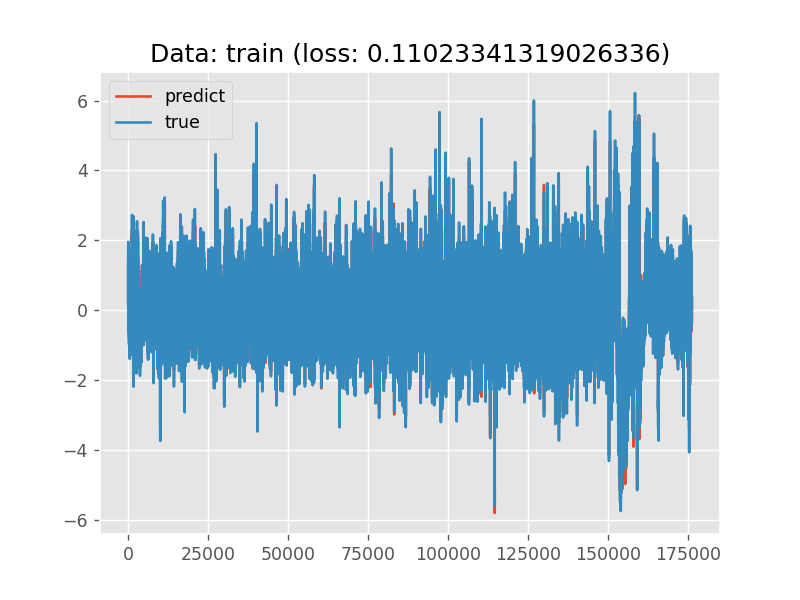

In [91]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = True
    
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'
    
#x = x.to(device)
model.to('cpu')
predict = modelCPU(x).cpu().detach().numpy()
model.to(device)

if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'Data: ' + trainTitle + ' (loss: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

# SCRATCH BELOW

In [ ]:
import neptune

# Create a Neptune run object
run = neptune.init_run(
    project='jettinger35/test',
    api_token=api_token,  
)

# Track metadata and hyperparameters by assigning them to the run
run["JIRA"] = "NPT-952"
run["algorithm"] = "ConvNet"

PARAMS = {
    "batch_size": 64,
    "dropout": 0.2,
    "learning_rate": 0.001,
    "optimizer": "Adam",
}
run["parameters"] = PARAMS

# Track the training process by logging your training metrics
for epoch in range(10):
    run["train/accuracy"].append(epoch * 0.6)  
    run["train/loss"].append(epoch * 0.4)

# Record the final results
run["f1_score"] = 0.66

# Stop the connection and synchronize the data with the Neptune servers
run.stop()


# SCRATCH

In [60]:
from scipy.signal import spectrogram, stft, istft, check_NOLA

fs = 1
nperseg = 32
noverlap = 31
#windowType = ('tukey', .25)
windowType = np.ones(nperseg)


a = np.random.rand(100)
f, t, S = stft(a, fs=fs, window=windowType, nperseg=nperseg, noverlap=noverlap)

b = torch.stft(torch.tensor(a), 
               n_fft = nperseg, 
               hop_length = 1, 
               return_complex=True, 
               normalized=False, 
               onesided=True, 
               pad_mode='constant').numpy()

np.abs(np.divide(b,S))

array([[32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       ...,
       [32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.],
       [32., 32., 32., ..., 32., 32., 32.]])

In [50]:
project = neptune.init_project(project="jettinger35/predictScalp")
df = project.fetch_runs_table().to_pandas()
df[['sys/id','best_test_loss']]

https://new-ui.neptune.ai/jettinger35/predictScalp/


sys/id  best_test_loss
0   PRED-34        0.417772
2   PRED-32        0.408214
3   PRED-31        0.409690
4   PRED-30             NaN
5   PRED-29             NaN
6   PRED-28             NaN
7   PRED-27             NaN
8   PRED-26             NaN
9   PRED-25             NaN
10  PRED-24             NaN
11  PRED-23             NaN
12  PRED-21             NaN
13  PRED-20             NaN
14  PRED-18             NaN
15  PRED-16             NaN
16  PRED-14             NaN
17  PRED-13             NaN
18  PRED-12             NaN
19  PRED-11             NaN
20  PRED-10             NaN
22   PRED-8             NaN
1   PRED-33             NaN
21   PRED-9             NaN
23   PRED-7             NaN
24   PRED-6             NaN
25   PRED-5             NaN
26   PRED-4             NaN
27   PRED-3             NaN
28   PRED-2             NaN